#**Pengembangan Chatbot AI untuk Layanan Pelanggan PLN Menggunakan Algoritma Bidirectional Long Short Term Memory (BiLSTM)**

In [1]:
# ================================================================
# Chatbot PLN - Training dengan Dataset Augment (Colab Ready)
# ================================================================
# Fitur:
# - Load dataset augmented: pertanyaan, jawaban, intent, pertanyaan_clean
# - Preprocessing konsisten (normalize Indo + cleaning)
# - Tokenizer (OOV), Padding
# - Model: Embedding(mask_zero) -> BiLSTM -> Dense + Dropout
# - Callbacks: EarlyStopping, ReduceLROnPlateau
# - Evaluasi: Accuracy, Macro-F1, Precision, Recall, Classification Report, Confusion Matrix
# - Dialog Manager: Classifier (threshold) -> TF-IDF retrieval -> default fallback
# - Interaksi: chat() via input() (opsional Gradio -> diabaikan)
# - Logging unknown queries + simpan artefak model
# ================================================================

# ========================
#  Library Imports
# ========================

# Built-in
import os
import re
import json
import string
import random
import pickle
from collections import Counter

# Data Handling
import numpy as np
import pandas as pd

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Sklearn Utilities
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    f1_score, precision_score, recall_score
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Visualisasi & Ekstra
import matplotlib.pyplot as plt
import scipy.sparse as sp

import warnings
%matplotlib inline
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 99


# Konfigurasi Awal dan Penetapan Seed

Sel ini digunakan untuk mengatur **konfigurasi dasar proyek** serta menetapkan **seed random** agar hasil eksperimen menjadi *reproducible* (hasil pelatihan model tetap konsisten setiap kali dijalankan). Selain itu, sel ini juga mendefinisikan lokasi dataset dan parameter penting seperti ambang batas (threshold) untuk klasifikasi dan retrieval chatbot.

**Input / Variabel penting**
- `SEED`: nilai acak tetap (default = 42) agar proses pelatihan dapat direproduksi.
- `DATASET_PATH`: path menuju dataset utama chatbot PLN dalam format CSV.
- `CONFIDENCE_THRESHOLD`: batas minimal probabilitas agar chatbot menganggap prediksi yakin (contoh: jika < 0.6 → dianggap tidak pasti).
- `RETRIEVAL_THRESHOLD`: batas untuk menentukan apakah chatbot perlu melakukan pencarian jawaban berbasis *retrieval*.



In [2]:
# ========================
# Konfigurasi dan Seed
# ========================

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Path dan Parameter
DATASET_PATH = "/content/dataset.csv"

# Threshold untuk klasifikasi dan retrieval
CONFIDENCE_THRESHOLD = 0.60
RETRIEVAL_THRESHOLD = 0.35

# Informasi awal
print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.19.0


# Memuat Dataset Chatbot PLN

Sel ini memuat dataset utama chatbot PLN dari file CSV, lalu menampilkan 1 contoh acak dari setiap intent untuk memastikan struktur data terbaca dengan baik. Dataset berisi kolom `intent`, `pertanyaan`, dan `jawaban`, yang digunakan untuk klasifikasi dan pelatihan model. Juga ditampilkan jumlah intent unik sebagai validasi awal distribusi data.


In [3]:
df = pd.read_csv(DATASET_PATH)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Ambil 1 contoh acak per intent
contoh_per_intent = df.groupby("intent").sample(1, random_state=42).reset_index(drop=True)

# Tampilkan hasil
display(contoh_per_intent)
print(f"Jumlah intent unik: {df['intent'].nunique()}")


,intent,pertanyaan,jawaban,pertanyaan_clean
0,apa_itu_PLN,apakah PLN Indonesia termasuk perusahaan negara?,"PLN adalah Perusahaan Listrik Negara (BUMN) yang bertugas menyediakan layanan ketenagalistrikan di Indonesia, mencakup pembangkitan, transmisi, distribusi, dan pelayanan pelanggan.",apakah pln indonesia termasuk perusahaan negara
1,bayar_tagihan,prosedur melakukan pembayaran rekening listrik di aplikasi?,"Anda bisa membayar tagihan listrik melalui bank, ATM, internet/mobile banking, minimarket, e-wallet, virtual account, atau aplikasi PLN Mobile.",prosedur melakukan pembayaran rekening listrik di aplikasi
2,cek_tagihan,Cara cek tagihan listrik pascabayar.,"Untuk mengecek tagihan listrik, gunakan PLN Mobile (menu Tagihan) atau situs resmi PLN. Anda juga dapat melihat riwayat tagihan dan status pembayaran di aplikasi.",cara cek tagihan listrik pascabayar
3,gangguan,"mau lapor, ada gangguan di jalan garuda.","Untuk gangguan, laporkan via PLN Mobile (menu Pengaduan) atau hubungi 123 yang tersedia 24 jam.",mau lapor ada gangguan di jalan garuda
4,layanan_PLN,Customer service PLN melayani apa saja?,"PLN menyediakan layanan sambungan baru, tambah daya, cek dan bayar tagihan, pengaduan dan informasi gangguan/pemadaman, token prabayar, serta informasi tarif. Layanan tersedia melalui PLN Mobile, situs resmi PLN, dan kanal resmi lainnya.",customer service pln melayani apa saja
5,pemeliharaan,cara cek jadwal mati listrik bergilir lewat website PLN?,"Informasi pemadaman listrik (terencana/insidental) dapat dicek di PLN Mobile (menu Info Pemadaman) atau situs resmi PLN. Detail wilayah terdampak, jadwal mulai/selesai, dan estimasi penormalan ditampilkan di aplikasi. Untuk keadaan darurat, hubungi 123.",cara cek jadwal mati listrik bergilir lewat website pln
6,pengaduan,bagaimana membuat komplain pemadaman tidak terjadwal di jakarta secara online?,"Untuk pengaduan, gunakan PLN Mobile (menu Pengaduan) atau hubungi 123. Sertakan ID pelanggan/nomor meter, alamat lengkap, detail kendala, serta foto bila perlu. Status penanganan dapat dipantau di aplikasi.",bagaimana membuat komplain pemadaman tidak terjadwal di jakarta secara online
7,penutup,Dah,"Terima kasih telah menghubungi PLN. Jika ada pertanyaan lain, silakan hubungi kembali.",dah
8,perkenalan,bisa bantu jawab tentang pln?,Saya adalah asisten virtual PLN yang siap membantu pertanyaan Anda.,bisa bantu jawab tentang pln
9,pindah_tiang,Mau tanya soal memindahkan tiang listrik.,"Permohonan pemindahan/relokasi tiang listrik dapat diajukan melalui PLN Mobile (menu Pengaduan atau Permohonan sesuai ketersediaan wilayah). Sertakan detail lokasi, foto kondisi, dan koordinat. Biaya mengacu pada ketentuan setelah survei. Jadwal survei dan pekerjaan akan diinformasikan melalui aplikasi.",mau tanya soal memindahkan tiang listrik


Jumlah intent unik: 16


# Visualisasi Distribusi Data per Intent

Sel ini menampilkan **visualisasi distribusi jumlah data untuk setiap intent** dalam dataset chatbot PLN. Tujuannya adalah untuk memahami apakah dataset seimbang (*balanced*) atau tidak. Visualisasi menggunakan *bar plot* dari Seaborn agar lebih informatif dan mudah dibaca.





Jumlah total data: 2779


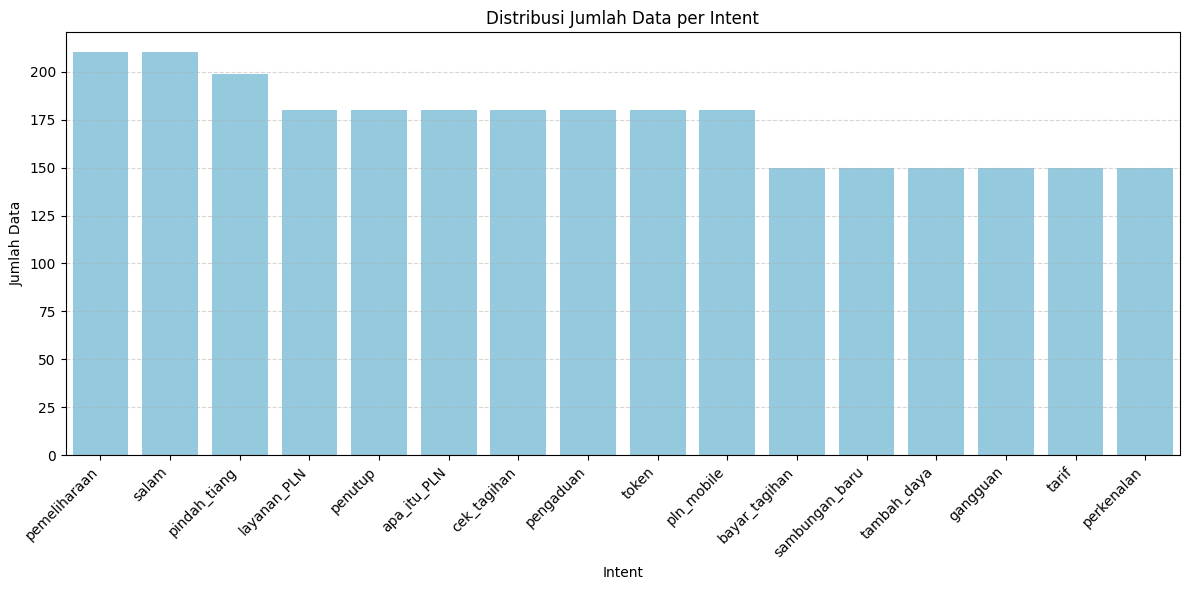

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Hitung jumlah total data
print("Jumlah total data:", len(df))

# Hitung jumlah data per intent
intent_counts = df["intent"].value_counts().reset_index()
intent_counts.columns = ["Intent", "Jumlah"]

# Visualisasi
plt.figure(figsize=(12, 6))
sns.barplot(data=intent_counts, x="Intent", y="Jumlah", color="skyblue")

plt.title("Distribusi Jumlah Data per Intent")
plt.xlabel("Intent")
plt.ylabel("Jumlah Data")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Visualisasi WordCloud dari Dataset Pertanyaan

Kode berikut melakukan visualisasi **WordCloud** berdasarkan frekuensi kata yang muncul dalam kolom `pertanyaan` pada dataset. Visualisasi ini membantu untuk melihat kata-kata yang paling sering muncul secara visual dengan ukuran kata yang proporsional terhadap frekuensinya.

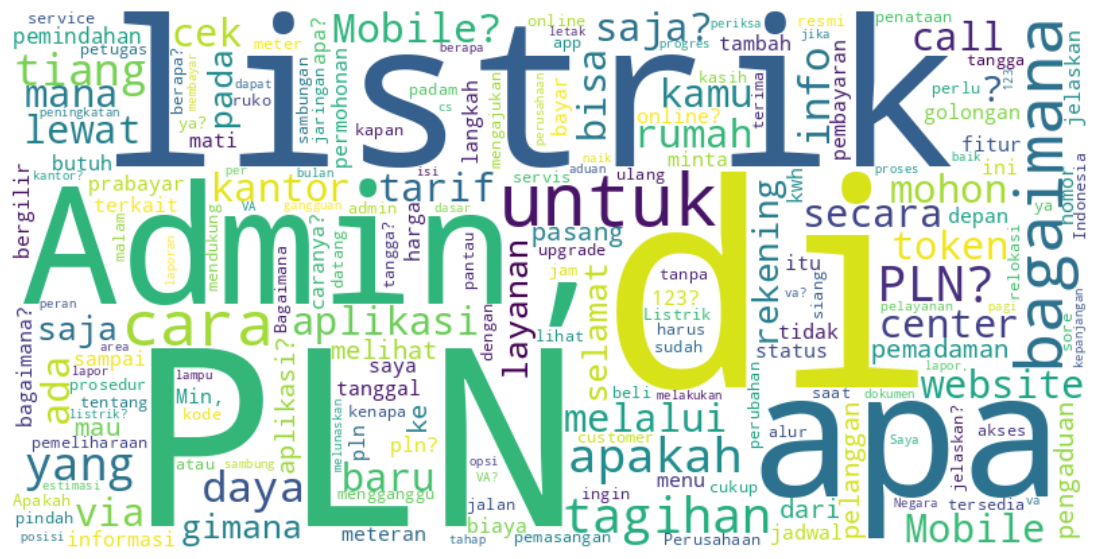

In [5]:
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Tokenisasi (misal sudah berupa list kata)
all_words = [word for text in df["pertanyaan"] for word in text.split()]

# Hitung frekuensi kata
word_freq = Counter(all_words)

# Visualisasi WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_freq)
plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Preprocessing Teks Bahasa Indonesia (Normalisasi Konsisten)

Sel ini melakukan pembersihan dan normalisasi teks pertanyaan agar seragam dan siap diproses model. Proses mencakup lowercase, penghapusan tanda baca, penggantian kata tidak baku (*slang*), serta pembuangan partikel tidak penting. Hasil akhir disimpan di kolom `pertanyaan_clean` yang akan digunakan sebagai input model.


In [6]:
# Daftar kata slang & padanan normalnya
SLANG_MAP = {
    "gimana": "bagaimana", "gmn": "bagaimana",
    "ga": "tidak", "gak": "tidak", "nggak": "tidak", "ngga": "tidak",
    "klo": "kalau", "kl": "kalau",
    "dgn": "dengan", "yg": "yang", "utk": "untuk", "sdh": "sudah", "udh": "sudah",
    "bgt": "sangat", "banget": "sangat",
    "min": "admin", "bos": "admin", "bro": "admin",
    "pengen": "ingin", "infoo": "informasi",
    "sih": "", "deh": "", "dong": "", "ya": "", "yah": "", "nih": "", "lah": ""
}

def normalize_indonesian(text: str) -> str:
    """Normalisasi teks bahasa Indonesia: lower, hapus punctuation/digit, slang, spasi."""
    text = text.lower()
    text = re.sub(r"[%s]" % re.escape(string.punctuation), " ", text)
    text = re.sub(r"\s+", " ", text).strip()  # hapus spasi berlebih
    tokens = []
    for word in text.split():
        replacement = SLANG_MAP.get(word, word)
        if replacement:  # hanya tambahkan jika tidak kosong
            tokens.append(replacement)
    return " ".join(tokens)

# Cek dan proses kolom pertanyaan
if "pertanyaan" in df.columns:
    df["pertanyaan"] = df["pertanyaan"].astype(str)
    df["pertanyaan_clean"] = df["pertanyaan"].apply(normalize_indonesian)
else:
    raise ValueError("Kolom 'pertanyaan' tidak ditemukan dalam dataset.")


# Encoding Label Intent & Pemetaan Jawaban

Sel ini mengubah label intent menjadi angka menggunakan `LabelEncoder` dan membuat kamus `intent2answer` yang memetakan setiap intent ke jawaban paling sering muncul di dataset.

**Input / Variabel penting**  
- `df["intent"]`: kolom label intent.  
- `LabelEncoder` dari `sklearn`.  
- `Counter` untuk hitung frekuensi jawaban.  

**Output / Hasil yang diharapkan**  
- `y_int`: label intent dalam bentuk numerik.  
- `num_intents`: jumlah intent unik.  
- Kamus `intent2answer` untuk respon chatbot.



In [7]:
# ----------------------------
# 3) Label Encoder (INTENT)
#    -> klasifikasi ke intent ; jawaban dipetakan dari intent
# ----------------------------
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder
from collections import defaultdict, Counter # Import Counter
le_intent = LabelEncoder()
y_int = le_intent.fit_transform(df["intent"].astype(str))
num_intents = len(le_intent.classes_)
print("Jumlah intent:", num_intents, "| Daftar intent:", list(le_intent.classes_))

# siapkan kamus intent->jawaban (ambil jawaban paling sering agar stabil)
from collections import defaultdict
intent2answer = {}
for intent, sub in df.groupby("intent"):
    most_common = Counter(sub["jawaban"]).most_common(1)[0][0]
    intent2answer[intent] = most_common

Jumlah intent: 16 | Daftar intent: ['apa_itu_PLN', 'bayar_tagihan', 'cek_tagihan', 'gangguan', 'layanan_PLN', 'pemeliharaan', 'pengaduan', 'penutup', 'perkenalan', 'pindah_tiang', 'pln_mobile', 'salam', 'sambungan_baru', 'tambah_daya', 'tarif', 'token']


# Tokenisasi dan Padding Teks

Sel ini mengubah teks pertanyaan yang sudah dinormalisasi menjadi angka menggunakan `Tokenizer` Keras, lalu melakukan padding agar semua urutan memiliki panjang sama untuk input model.

**Input / Variabel penting**  
- `MAX_VOCAB`: batas maksimal kata unik dalam kamus (default 8000).  
- `texts`: daftar pertanyaan bersih.  
- `tokenizer`: objek Keras `Tokenizer`.  
- `max_len`: panjang maksimal sequence hasil tokenisasi.

**Output / Hasil yang diharapkan**  
- `X`: array 2D dengan sequence angka hasil padding.  
- `vocab_size`: ukuran kamus kata yang dipakai.  
- Info `Vocab size` dan `max_len` dicetak.




In [8]:
# ----------------------------
# 4) Tokenizer & Padding
# ----------------------------
from tensorflow.keras.preprocessing.text import Tokenizer # Import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences # Import pad_sequences

MAX_VOCAB = 8000
OOV = "<OOV>"
texts = df["pertanyaan_clean"].astype(str).tolist()

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token=OOV, filters="")
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)
max_len = max(3, max(len(s) for s in sequences))  # minimal 3 agar aman
X = pad_sequences(sequences, maxlen=max_len, padding="post")
vocab_size = min(MAX_VOCAB, len(tokenizer.word_index) + 1)
print("Vocab size:", vocab_size, "| max_len:", max_len)

Vocab size: 771 | max_len: 21


# Pembagian Dataset: Training, Validation, dan Testing

Sel ini membagi dataset menjadi training (70%), validation (10%), dan testing (20%) secara stratifikasi agar distribusi intent tetap seimbang di setiap subset.

**Input / Variabel penting**  
- `X`: fitur hasil padding.  
- `y_int`: label intent numerik.  
- `SEED`: random seed untuk konsistensi.  

- Dataset terbagi menjadi `X_train`, `X_val`, `X_test`, dan label `y_train`, `y_val`, `y_test`.  
- Jumlah sampel tiap subset dicetak.



In [9]:
# ----------------------------
# 5) Split Data: Training - Validation - Testing
# ----------------------------
from sklearn.model_selection import train_test_split

# Langkah 1: Pisahkan 20% untuk test set (benar-benar terpisah)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_int, test_size=0.2, random_state=SEED, stratify=y_int
)

# Langkah 2: Dari 80% sisanya, pisahkan menjadi 70% training dan 10% validation
# (dari total: 70% train, 10% val, 20% test)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.125, random_state=SEED, stratify=y_temp  # 0.125 dari 80% = 10% dari total
)

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")


Training set: 1945 samples
Validation set: 278 samples
Test set: 556 samples


# Membangun Arsitektur Model BiLSTM untuk Klasifikasi Intent

Sel ini membangun **model deep learning berbasis BiLSTM (Bidirectional Long Short-Term Memory)** menggunakan Keras Sequential API. Model ini digunakan untuk mengenali *intent* dari pertanyaan pengguna chatbot PLN. Arsitektur terdiri dari lapisan embedding, BiLSTM dua arah, dan beberapa lapisan dense dengan dropout untuk mencegah overfitting.

**Struktur model**
1. **Embedding Layer**  
   Mengubah setiap token (angka) menjadi representasi vektor berdimensi tetap (`EMB_DIM`).  
2. **Bidirectional LSTM Layer**  
   Mempelajari konteks kalimat dari arah maju dan mundur sekaligus agar pemahaman makna lebih kuat.  
3. **Dense + Dropout Layers**  
   Menyaring fitur penting dan menambahkan regularisasi (`DROPOUT`) agar model tidak mudah overfit.  
4. **Output Layer (Softmax)**  
   Menghasilkan probabilitas untuk setiap intent (klasifikasi multi-kelas).

**Input / Variabel penting**
- `vocab_size`: jumlah kata unik dalam dataset (input untuk embedding).  
- `max_len`: panjang maksimum sequence teks.  
- `EMB_DIM`: dimensi embedding (semakin besar → representasi kata lebih kaya, tapi butuh lebih banyak memori).  
- `LSTM_UNITS`: jumlah neuron dalam layer BiLSTM (default 128).  
- `DROPOUT`: rasio dropout untuk regularisasi (default 0.35).  
- `num_intents`: jumlah kategori intent yang akan diprediksi.  

**Output / Hasil yang diharapkan**
- Ringkasan model (`model.summary()`) menampilkan jumlah parameter trainable dan struktur layer.  
- Model siap untuk tahap kompilasi dan pelatihan.

**Catatan & tips**
- `mask_zero=True` memungkinkan embedding mengabaikan padding (nilai 0) saat memproses sequence.  
- `return_sequences=False` karena hanya hasil akhir dari BiLSTM yang diperlukan untuk klasifikasi, bukan setiap langkah waktu.  
- Dropout pada dua titik (setelah BiLSTM dan Dense) membantu mengurangi overfitting.  
- Jika GPU tersedia, BiLSTM dapat berjalan lebih cepat dibanding CPU.  

In [10]:
# ----------------------------
# 6) Model: Embedding -> BiLSTM -> Dense
# ----------------------------
from tensorflow.keras.models import Sequential # Import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout # Import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # Import callbacks
from sklearn.utils.class_weight import compute_class_weight # Import compute_class_weight

EMB_DIM = 96
LSTM_UNITS = 128
DROPOUT = 0.35

model = Sequential(name="PLN_Chatbot_BiLSTM_Intent")
model.add(Embedding(input_dim=vocab_size, output_dim=EMB_DIM, input_length=max_len, mask_zero=True, name="embedding"))
model.add(Bidirectional(LSTM(LSTM_UNITS, return_sequences=False, name="bilstm"), name="bidir")) # return_sequences=False for classification
model.add(Dropout(DROPOUT))
model.add(Dense(128, activation="relu"))
model.add(Dropout(DROPOUT))
model.add(Dense(num_intents, activation="softmax"))

# build for summary
model(np.zeros((1, max_len)))
model.summary()

Model: "PLN_Chatbot_BiLSTM_Intent"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (1, 21, 96)            │        74,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidir (Bidirectional)           │ (1, 256)               │       230,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (1, 256)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (1, 128)               │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (1, 128)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (1, 16)                │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 339,376 (1.29 MB)

 Trainable params: 339,376 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

# Kompilasi dan Pelatihan Model BiLSTM

Sel ini mengatur **proses kompilasi dan pelatihan model BiLSTM** untuk mengenali *intent* dari pertanyaan pengguna chatbot PLN.  
Langkah-langkahnya mencakup:
1. Menentukan fungsi *loss*, *optimizer*, dan *metrics* evaluasi.  
2. Menghitung **class weights** agar model tidak bias terhadap kelas yang jumlah datanya tidak seimbang.  
3. Menggunakan **callback** seperti *EarlyStopping* dan *ReduceLROnPlateau* untuk mengoptimalkan proses pelatihan dan mencegah overfitting.  
4. Menjalankan pelatihan model dengan data training dan validation.

**Input / Variabel penting**
- **Loss function:** `"sparse_categorical_crossentropy"` untuk klasifikasi multi-kelas dengan label integer.  
- **Optimizer:** `Adam` dengan `learning_rate=3e-3`, efektif untuk model berbasis LSTM.  
- **Metrics:** `accuracy` untuk mengukur akurasi prediksi intent.  
- **class_weight_dict:** bobot kelas agar kelas minoritas diberi penekanan lebih saat training.  
- **Callbacks:**  
  - `EarlyStopping`: menghentikan pelatihan jika *val_loss* tidak membaik selama 10 epoch.  
  - `ReduceLROnPlateau`: menurunkan *learning rate* sebesar 0.5 jika *val_loss* stagnan selama 5 epoch.

**Output / Hasil yang diharapkan**
- Proses training model (`model.fit`) dengan laporan *loss* dan *accuracy* tiap epoch.  
- Objek `history` yang menyimpan metrik pelatihan untuk keperluan visualisasi (akurasi & loss).  
- Model terlatih dengan bobot terbaik secara otomatis (berkat `restore_best_weights=True`).

**Catatan & tips**
- Jika *val_loss* naik terus, coba turunkan *learning rate* awal (misal `1e-3` atau `5e-4`).  
- *EarlyStopping* menjaga efisiensi pelatihan dan mencegah model overfit terhadap data training.  
- Gunakan `class_weight` hanya jika distribusi intent tidak seimbang — jika data sudah seimbang, ini bisa dihapus.  
- Parameter `epochs=80` cukup besar, tetapi pelatihan biasanya berhenti lebih awal karena *early stopping*.



In [11]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-3),
    metrics=["accuracy"]
)

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))


es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)
rlr = ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.5, min_lr=1e-5, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[es, rlr],
    verbose=1
)

Epoch 1/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.2631 - loss: 2.3789 - val_accuracy: 0.8777 - val_loss: 0.4742 - learning_rate: 0.0030
Epoch 2/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9066 - loss: 0.3373 - val_accuracy: 0.9532 - val_loss: 0.1856 - learning_rate: 0.0030
Epoch 3/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9632 - loss: 0.1294 - val_accuracy: 0.9856 - val_loss: 0.0687 - learning_rate: 0.0030
Epoch 4/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9844 - loss: 0.0523 - val_accuracy: 0.9604 - val_loss: 0.1540 - learning_rate: 0.0030
Epoch 5/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9901 - loss: 0.0369 - val_accuracy: 0.9532 - val_loss: 0.1880 - learning_rate: 0.0030
Epoch 6/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9792 - loss: 0.0821 - val_accuracy: 0.9424 - val_loss: 0.2468 - learning_rate: 0.0030
Epoch 7/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9848 - loss: 0.0435 - val_accura

# Visualisasi Performa Model: Akurasi dan Loss

Sel ini digunakan untuk **memvisualisasikan hasil pelatihan model BiLSTM** berdasarkan metrik *accuracy* dan *loss* pada data training serta validation. Grafik ini membantu memantau apakah model sudah konvergen, masih underfitting, atau mulai overfitting selama proses pelatihan.

**Input / Variabel penting**
- `history`: objek hasil `model.fit()` yang menyimpan metrik pelatihan dalam `history.history`.  
  - `history.history["accuracy"]`: akurasi pada data training.  
  - `history.history["val_accuracy"]`: akurasi pada data validation.  
  - `history.history["loss"]`: nilai loss pada data training.  
  - `history.history["val_loss"]`: nilai loss pada data validation.

**Output / Hasil yang diharapkan**
- Grafik **akurasi** (training vs validation).  
- Grafik **loss** (training vs validation).  
- Setiap grafik memiliki legenda, judul, dan garis pembeda yang mudah dibaca.

**Catatan & tips**
- Jika grafik akurasi *training* naik terus tetapi *validation* stagnan atau menurun → indikasi *overfitting*.  
- Jika kedua grafik masih meningkat bersamaan → model belum konvergen, bisa dilatih lebih lama.  
- Rentang sumbu bisa diatur agar grafik lebih proporsional, misalnya:


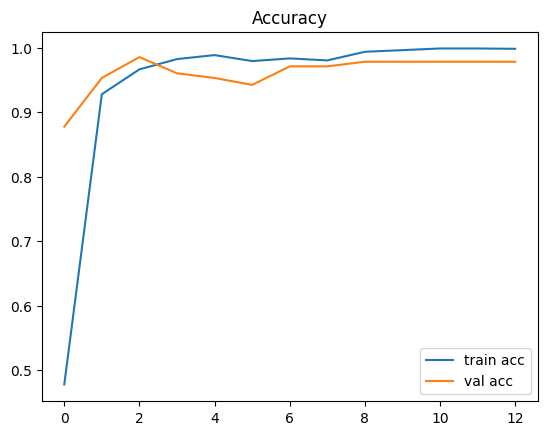

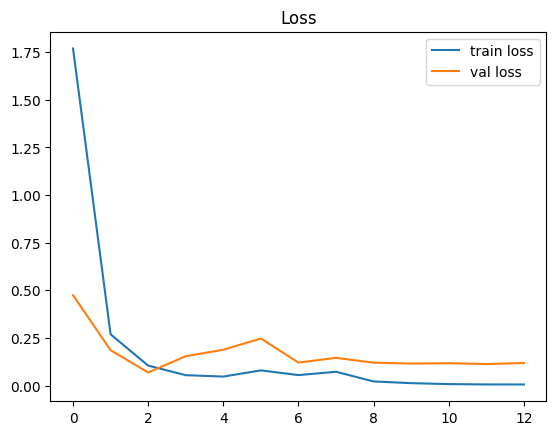

In [12]:
plt.figure()
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.legend(); plt.title("Accuracy"); plt.show()

plt.figure()
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend(); plt.title("Loss"); plt.show()

# Evaluasi Final pada Test Set
Mengukur kinerja akhir model BiLSTM pada data yang benar-benar tidak terlihat saat training (test set), menggunakan metrik klasifikasi multi-kelas.

- `model.predict(X_test)` → keluaran **probabilitas** per kelas (shape: `n_test × n_class`).
- `argmax(axis=1)` → konversi probabilitas menjadi **label prediksi** kelas tertinggi.
- Hitung metrik makro:
  - **Accuracy**: proporsi prediksi benar.
  - **F1 Macro**: rata-rata F1 tiap kelas (seimbang antar kelas).
  - **Precision Macro** & **Recall Macro**: rata-rata presisi & recall per kelas.
- `zero_division=0` mencegah error jika suatu kelas tidak diprediksi sama sekali (kembalikan 0 untuk presisi/recall kelas tersebut).

Karena intent kita banyak dan (idealnya) seimbang, **macro-averaging** mengevaluasi kemampuan model pada **semua intent** secara adil, bukan hanya intent yang paling sering. Ini penting untuk chatbot yang harus responsif pada beragam skenario layanan PLN.



In [13]:
# ----------------------------
# 8) Evaluasi Final pada Test Set
# ----------------------------
print("\n=== EVALUASI FINAL PADA TEST SET ===")
y_test_prob = model.predict(X_test, verbose=0)
y_test_pred = np.argmax(y_test_prob, axis=1)

# Hitung metrik untuk test set
test_acc = (y_test_pred == y_test).mean()
test_f1_macro = f1_score(y_test, y_test_pred, average="macro")
test_prec_macro = precision_score(y_test, y_test_pred, average="macro", zero_division=0)
test_rec_macro = recall_score(y_test, y_test_pred, average="macro", zero_division=0)

print(f"Test Accuracy : {test_acc:.2f}")
print(f"Test F1 Macro : {test_f1_macro:.2f}")
print(f"Test Precision: {test_prec_macro:.2f}")
print(f"Test Recall   : {test_rec_macro:.2f}\n")


=== EVALUASI FINAL PADA TEST SET ===
Test Accuracy : 0.97
Test F1 Macro : 0.97
Test Precision: 0.97
Test Recall   : 0.97



# Confusion Matrix (Validasi & Test)
Memvisualisasikan kesalahan model BiLSTM per‐kelas intent. Matriks kebingungan menunjukkan berapa banyak sampel dari kelas **sebenarnya** (baris) diprediksi ke kelas **tertentu** (kolom).

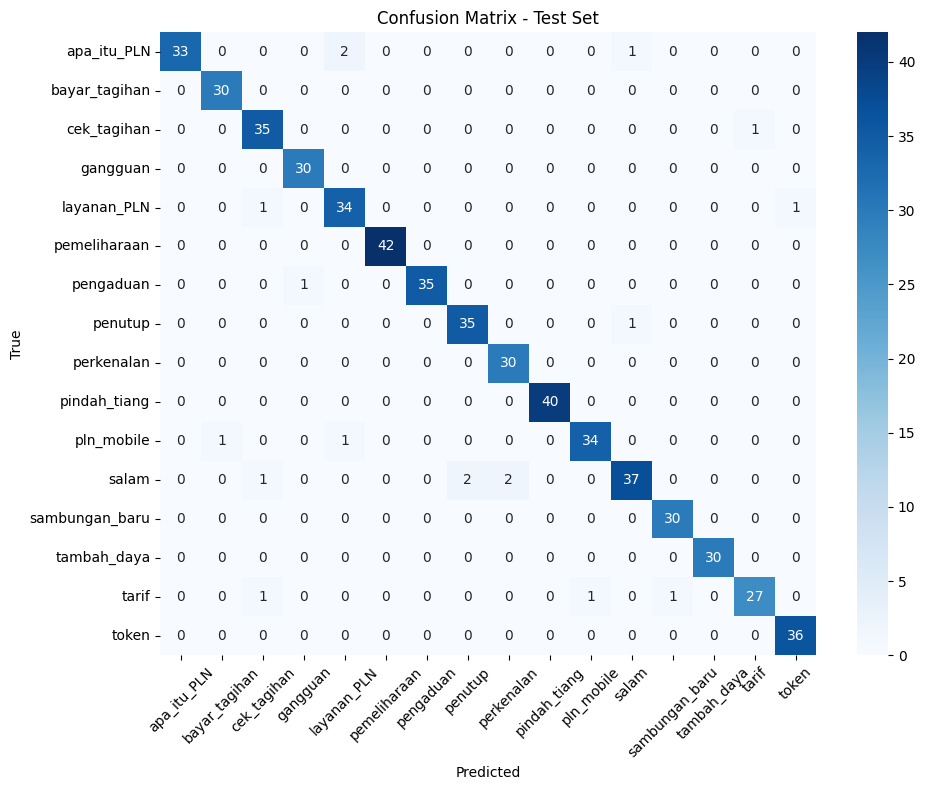

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(true_labels, pred_labels, class_names,
                         title='Confusion Matrix', figsize=(10,8)):
    plt.figure(figsize=figsize)
    cm = confusion_matrix(true_labels, pred_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# --- Contoh penggunaan untuk Validation Set ---
# Generate predictions for the validation set
y_val_prob = model.predict(X_val, verbose=0)
y_val_pred = np.argmax(y_val_prob, axis=1)


# --- Contoh penggunaan untuk Test Set (ganti inputnya) ---
plot_confusion_matrix(y_test, y_test_pred, le_intent.classes_,
                     title='Confusion Matrix - Test Set', figsize=(10,8))

# TF-IDF Retrieval (Fallback Jawaban FAQ)
Menyediakan **mekanisme cadangan** (retrieval‐based) ketika prediksi BiLSTM kurang yakin/di luar cakupan. Sistem akan mencari jawaban paling mirip dari **FAQ PLN** menggunakan kesamaan TF-IDF.


- `TfidfVectorizer().fit_transform(df["pertanyaan_clean"])` → bangun matriks TF-IDF seluruh pertanyaan FAQ.
- Simpan `qa_answers` sebagai daftar jawaban berurutan sesuai baris TF-IDF.
- `tfidf_retrieve(user_text, topk)`:
  - Normalisasi input dengan `normalize_indonesian` (sinkron dengan preprocessing train).
  - Vektorkan query → hitung **cosine similarity** ke seluruh pertanyaan.
  - Ambil indeks Top-K dengan skor tertinggi dan kembalikan pasangan `(jawaban, skor)`.

Bila model intent/seq2seq ragu (confidence rendah) atau tidak mengenali intent, fallback TF-IDF memastikan chatbot tetap **memberikan jawaban relevan** dari basis FAQ, mengurangi respon default “tidak paham”.

**Catatan cepat / opsi:**
- Atur **ambang** (mis. `if max_score < 0.25: pakai respons default`) agar tidak memaksakan jawaban mirip-mirip.
- Pertimbangkan `ngram_range=(1,2)` dan `min_df` kecil untuk menangkap frasa umum seperti “tambah daya”.
- Untuk performa lebih baik pada dataset besar, gunakan **faiss/Annoy** atau simpan `tfidf_matrix` & `tfidf.vocabulary_` ke disk.

In [15]:
# ----------------------------
# 8) TF-IDF Retrieval (fallback)
# ----------------------------
from sklearn.feature_extraction.text import TfidfVectorizer # Import TfidfVectorizer
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df["pertanyaan_clean"])
qa_answers = df["jawaban"].tolist()

def tfidf_retrieve(user_text, topk=1):
    q = normalize_indonesian(user_text)
    vec = tfidf.transform([q])
    sims = cosine_similarity(vec, tfidf_matrix)[0]
    idxs = sims.argsort()[::-1][:topk]
    return [(qa_answers[i], float(sims[i])) for i in idxs]

### Inference

In [16]:
# ----------------------------
# 9) Dialog Manager
# ----------------------------
DEFAULT_MSG = "Maaf, saya belum memahami pertanyaan Anda. Silakan coba dengan kalimat lain atau hubungi PLN 123."

def predict_intent(user_text):
    t = normalize_indonesian(user_text)
    seq = tokenizer.texts_to_sequences([t])
    pad = pad_sequences(seq, maxlen=max_len, padding="post")
    prob = model.predict(pad, verbose=0)[0]
    idx = int(np.argmax(prob))
    conf = float(np.max(prob))
    return idx, conf

def intent_to_answer(intent_label):
    # Jawaban stabil = modus per intent
    return intent2answer.get(intent_label, DEFAULT_MSG)

def chatbot_response(user_text, conf_thresh=CONFIDENCE_THRESHOLD, retrieval_thresh=RETRIEVAL_THRESHOLD, show_meta=True):
    # 1) Intent classifier
    idx, conf = predict_intent(user_text)
    intent_label = le_intent.inverse_transform([idx])[0]
    if conf >= conf_thresh:
        ans = intent_to_answer(intent_label)
        return f"{ans} (intent:{intent_label}, conf:{conf:.2f})" if show_meta else ans

    # 2) Retrieval fallback
    cand = tfidf_retrieve(user_text, topk=1)
    if cand and cand[0][1] >= retrieval_thresh:
        ans, sim = cand[0]
        return f"{ans} (retrieval sim:{sim:.2f})" if show_meta else ans

    # 3) Default + log
    try:
        pd.DataFrame([{"query": user_text}]).to_csv(UNKNOWN_LOG, mode="a", header=not os.path.exists(UNKNOWN_LOG), index=False)
    except Exception as e:
        print("Gagal menulis log unknown:", e)
    return DEFAULT_MSG

# Quick smoke test
tests = [
    "info", "Apa itu PLN", "Cara cek tagihan listrik", "Bagaimana bayar listrik",
    "Listrik mati di komplek, gimana lapornya", "Tarif listrik terbaru berapa",
    "Nomor pengaduan PLN", "Kamu siapa", "Makasih",
    "Upgrade daya 900 ke 1300 gimana", "Download PLN Mobile dimana",
    "Jadwal mati lampu besok ada ga?", "Prosedur pindah tiang listrik gimana?"
]
print("\n== QUICK CHAT TEST ==")
for q in tests:
    print("Q:", q)
    print("A:", chatbot_response(q))
    print("-"*60)


== QUICK CHAT TEST ==
Q: info
A: Hai, selamat datang di layanan informasi PLN. Apa yang ingin Anda ketahui?? (retrieval sim:1.00)
------------------------------------------------------------
Q: Apa itu PLN
A: PLN adalah Perusahaan Listrik Negara (BUMN) yang bertugas menyediakan layanan ketenagalistrikan di Indonesia, mencakup pembangkitan, transmisi, distribusi, dan pelayanan pelanggan. (intent:apa_itu_PLN, conf:0.94)
------------------------------------------------------------
Q: Cara cek tagihan listrik
A: Untuk mengecek tagihan listrik, gunakan PLN Mobile (menu Tagihan) atau situs resmi PLN. Anda juga dapat melihat riwayat tagihan dan status pembayaran di aplikasi. (intent:cek_tagihan, conf:0.97)
------------------------------------------------------------
Q: Bagaimana bayar listrik
A: Anda bisa membayar tagihan listrik melalui bank, ATM, internet/mobile banking, minimarket, e-wallet, virtual account, atau aplikasi PLN Mobile. (retrieval sim:0.60)
----------------------------------

### simpan model

In [17]:
# ----------------------------
# 12) Simpan Artefak
# ----------------------------
ARTIFACT_DIR = "/mnt/data"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

model_path = os.path.join(ARTIFACT_DIR, "pln_intent_bilstm.h5")
tokenizer_path = os.path.join(ARTIFACT_DIR, "pln_tokenizer.json")
le_path = os.path.join(ARTIFACT_DIR, "pln_intent_label_encoder.pkl")
intent_answer_path = os.path.join(ARTIFACT_DIR, "pln_intent2answer.json")
tfidf_path = os.path.join(ARTIFACT_DIR, "pln_tfidf.pkl")
tfidf_mat_path = os.path.join(ARTIFACT_DIR, "pln_tfidf_matrix.npz")

model.save(model_path)
with open(tokenizer_path, "w") as f:
    f.write(tokenizer.to_json())
with open(le_path, "wb") as f:
    pickle.dump(le_intent, f)
with open(intent_answer_path, "w", encoding="utf-8") as f:
    json.dump(intent2answer, f, ensure_ascii=False, indent=2)

# simpan TF-IDF & matrix
with open(tfidf_path, "wb") as f:
    pickle.dump(tfidf, f)
sp.save_npz(tfidf_mat_path, tfidf_matrix)

print("\nArtefak disimpan:")
print("-", model_path)
print("-", tokenizer_path)
print("-", le_path)
print("-", intent_answer_path)
print("-", tfidf_path)
print("-", tfidf_mat_path)


Artefak disimpan:
- /mnt/data/pln_intent_bilstm.h5
- /mnt/data/pln_tokenizer.json
- /mnt/data/pln_intent_label_encoder.pkl
- /mnt/data/pln_intent2answer.json
- /mnt/data/pln_tfidf.pkl
- /mnt/data/pln_tfidf_matrix.npz


In [18]:
import shutil
from google.colab import files

# 1. Tentukan path folder yang ingin diunduh
folder_path = '/mnt/data'

# 2. Tentukan nama untuk file zip yang akan dibuat (tanpa .zip)
output_filename = 'hasil_model'

# 3. Kompres folder menjadi file zip
shutil.make_archive(output_filename, 'zip', folder_path)

# 4. Unduh file zip yang sudah dibuat
zip_file_name = f"{output_filename}.zip"
print(f"Mengompres folder selesai. Mengunduh '{zip_file_name}'...")
files.download(zip_file_name)

Mengompres folder selesai. Mengunduh 'hasil_model.zip'...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>